# Temperature Profile Error
This takes the temperature profile averaged over hottest $x$% of days, and investigates several approximations to it.

In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

## Load in data
First load in the temperature profile. Then load in the surface pressure, and compute REFHT variables.

Also, compute the LCL, and lapse rates below and above this.

In [3]:
quant = 95
lat_use = slice(-60, 80)            # save time by only using certain latitudes
exp_path_prof ='/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/av_profile/above_TREFHTquant'
exp_name = ['pre_industrial', 'co2_2x']
n_exp = len(exp_name)
exp_labels = ['Pre industrial', '$CO_2 \\times 2$']
ds = []
# compute_offline = False             # If True, compute LCL etc from average profile, otherwise load in info averaged over values on each day
# if not compute_offline:
#     var_keep += ['T', 'T_zonal_av', 'T_anom', 'p_at_lcl', 'T_at_lcl', 'lapse_below_lcl', 'lapse_above_lcl']
for i in tqdm(range(n_exp)):
    ds.append(xr.open_dataset(f'{exp_path_prof}/T/{exp_name[i]}/output.nd2').sel(quant=quant, lat=lat_use)[['T']].load())
    ds[i]['Q'] = xr.open_dataset(f'{exp_path_prof}/Q/{exp_name[i]}/output.nd2').sel(quant=quant, lat=lat_use).Q.load()

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
surf_model_level = -3
var_keep = ['PS', 'p_at_lcl']
if surf_model_level is None:
    var_keep += ['TREFHT', 'QREFHT']
exp_path_surf = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa'
for i in tqdm(range(n_exp)):
    ds_use = xr.open_dataset(f'{exp_path_surf}/{exp_name[i]}/output.nd2').sel(quant=quant, lat=lat_use).isel(plev=0)[var_keep].load()
    for key in var_keep:
        ds[i][key] = ds_use[key]
    pressure_ft = float(ds[i].plev)
    ds[i] = ds[i].drop_vars('plev')
    ds[i] = ds[i].rename({"p_at_lcl": "p_at_lcl_online"})

  0%|          | 0/2 [00:00<?, ?it/s]

#### Invariant Data

In [5]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['LANDFRAC', 'PHIS']].sel(lat=lat_use)
invariant_data = invariant_data.reindex_like(ds[0]['PS'], method="nearest", tolerance=0.01).load()
# lsm = lsm_zhang
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1
ocean = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']<=0.5)*0+1
weights = np.cos(np.deg2rad(invariant_data.lat))
z2m = invariant_data.PHIS/g + 2

def get_lev_info(archive_dir='/Users/joshduffield/Documents/StAndrews/Isca/cesm/archive',
                 exp_name='test', year_files=41, hist_file=1):
    # Use test dataset to get
    ds = isca_tools.cesm.load_dataset(exp_name, archive_dir=archive_dir,
                                      hist_file=hist_file, year_files=year_files)
    return ds.hyam.isel(time=0), ds.hybm.isel(time=0), float(ds.P0.isel(time=0))
hyam, hybm, p0 = get_lev_info()

### Compute LCL and bulk lapse rates from average temperature profile
Below I compute the LCL, the environmental temperature at the LCL, and the bulk lapse rates above and below the LCL from the average temperature profile at each location.

In [6]:
for i in range(n_exp):
    ds[i]['p'] = isca_tools.cesm.get_pressure(ds[i].PS, p0, hyam, hybm)         # get pressure on model levels
    ds[i]['T_ft'] = interp_hybrid_to_pressure(ds[i].T, ds[i].PS, hyam, hybm, p0, np.atleast_1d(pressure_ft)).isel(plev=0)
    if surf_model_level is not None:
        ds[i]['TREFHT'] = ds[i]['T'].isel(lev=surf_model_level)
        ds[i]['QREFHT'] = ds[i]['Q'].isel(lev=surf_model_level)
        ds[i]['PREFHT'] = isca_tools.cesm.get_pressure(ds[i].PS, p0, hyam.isel(lev=surf_model_level), hybm.isel(lev=surf_model_level))
    else:
        ds[i].PREFHT = ds[i].PS         # REFHT pressure is same as surface pressure if use 2m values
    ds[i]['p_lcl'], ds[i]['T_lcl'] = lcl_metpy(ds[i].TREFHT, ds[i].QREFHT, ds[i].PREFHT)
    ds_use = interp_var_at_pressure(ds[i].T.drop_vars('plev'), ds[i].p_lcl.drop_vars('plev'), ds[i].PS.drop_vars('plev'), hyam, hybm, p0)
    ds[i]['T_at_lcl'] = ds_use.T
    ds[i]['p_at_lcl'] = ds_use.plev.transpose()
    ds[i]['lapse_below_lcl'] = get_bulk_lapse_rate(ds[i].TREFHT, ds[i].T_at_lcl, ds[i].PREFHT,
                                                   ds[i].p_at_lcl) * 1000
    ds[i]['lapse_above_lcl'] = get_bulk_lapse_rate(ds[i].T_at_lcl, ds[i].T_ft, ds[i].p_at_lcl, float(ds[i].plev)) * 1000
    ds[i].load()

In [8]:
# Only interested up to 500hPa, so only use certain levels
if ds[0].lev.min()<10:          # If have not already done lev slicing, do it here
    lev_use = {'min': min([int(np.abs(ds[i].p-pressure_ft).where(ds[i].p<=pressure_ft).argmin(dim='lev').min()) for i in range(n_exp)])}
    if surf_model_level is None or surf_model_level == -1:
        lev_use['max'] = ds[0].lev.size
    else:
        lev_use['max'] = surf_model_level + 1           # don't want to go below our REFHT
    hyam = hyam.isel(lev=slice(lev_use['min'], lev_use['max']))
    hybm = hybm.isel(lev=slice(lev_use['min'], lev_use['max']))
    for i in range(n_exp):
        ds[i] = ds[i].isel(lev=slice(lev_use['min'], lev_use['max']))

# Only interested in land
for i in range(n_exp):
    ds[i] = ds[i].where(land>0)

## Compute Approximations for Temperature Profile
Compare the actual temperature profile to various approximations.

In [9]:
def apply_func_vec(func, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * len(args) + [['lev']],
                          output_core_dims=[['lev']], vectorize=True, dask='parallelized', output_dtypes=[float])

def conv_neutral_profile(temp_lcl, p_lcl, p):
    if np.isnan(temp_lcl):
        return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

def moist_above_lcl_profile(temp_at_lcl, p_at_lcl, lapse_below_lcl, p):
    if np.isnan(temp_at_lcl):
        return temp_at_lcl * p  # if not land return numpy array of nans of same length as p
    # Follows constant lapse below LCL so matches environmental temp exactly at LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_at_lcl), float(p_at_lcl), p)
    temp_profile[p>=p_at_lcl] = reconstruct_temp(temp_at_lcl, p[p>=p_at_lcl], p[p>=p_at_lcl], p_at_lcl,
                                                 lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

def moist_above_lcl2_profile(temp_ft, p_ft, temp_refht, p_refht, p_lcl, p_surf, p):
    if np.isnan(temp_ft):
        return temp_ft * p          # if not land return numpy array of nans of same length as p
    # takes 5 mins
    # Follows moist adiabat from p_ft to p_lcl then follows constant lapse to surface
    temp_profile = moist_profile(float(temp_ft), float(p_ft), p)
    temp_at_lcl = interp_hybrid_to_pressure(xr.DataArray(temp_profile, dims='lev', coords={'lev': hybm.lev}),
                                            p_surf, hyam, hybm, p0, np.atleast_1d(p_lcl)).isel(plev=0)
    lapse_below_lcl = float(get_bulk_lapse_rate(temp_refht, temp_at_lcl, p_refht, p_lcl)) * 1000
    temp_profile[p>=p_lcl] = reconstruct_temp(float(temp_at_lcl), p[p>=p_lcl], p[p>=p_lcl], p_lcl,
                                              lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

def const_lapse_lcl_profile(temp_refht, p_refht, temp_at_lcl, p_at_lcl, lapse_below_lcl, lapse_above_lcl, p):
    temp_profile = reconstruct_temp(temp_at_lcl, p, p, p_at_lcl, lapse_above_lcl/1000, lapse_above_lcl/1000)
    temp_profile[p>=p_at_lcl] = reconstruct_temp(temp_refht, p[p>=p_at_lcl], p[p>=p_at_lcl], p_refht, lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile


def get_best_lev_split_prof(temp_refht, p_refht, temp_ft, p_ft, temp_lev, p, p_surface, plev_step=1000, error_mode='max'):
    # Returns 2 lapse rate profile, choosing the splitting point to minimise the error
    if 'plev' in temp_lev.coords:
        temp_lev = temp_lev.drop('plev')
    if 'plev' in p_surface:
        p_surface = p_surface.drop('plev')
    plevs_split_all = np.arange(round_any(float(p.min()), plev_step, 'floor'),
                                round_any(float(p.max()), plev_step, 'ceil')+plev_step/2, plev_step)
    plevs_split_all = xr.DataArray(plevs_split_all, dims="p_split", name="p_split")
    temp_split_all = interp_hybrid_to_pressure(data=temp_lev, ps=p_surface, hyam=hyam, hybm=hybm, p0=p0,
                                               new_levels=plevs_split_all.values, lev_dim='lev')
    temp_split_all = temp_split_all.rename({'plev': 'p_split'})     # must match plevs_split dimension
    temp_split_all = temp_split_all.load()          # load all first to make quicker
    # temp_lev is temperature at each model level
    # error_mode is way to quantify error between actual profile and constant lapse profile across all levels
    lapse_below_all = get_bulk_lapse_rate(temp_refht, temp_split_all, p_refht,
                                          plevs_split_all.expand_dims({'lat': temp_refht.lat, 'lon': temp_refht.lon})) * 1000
    lapse_above_all = get_bulk_lapse_rate(temp_split_all, temp_ft,
                                          plevs_split_all.expand_dims({'lat': temp_refht.lat, 'lon': temp_refht.lon}), p_ft) * 1000
    T_prof_all = []
    for j in range(plevs_split_all.size):
        T_prof_all.append(apply_func_vec(const_lapse_lcl_profile, p, temp_refht, p_refht, temp_split_all.isel(p_split=j),
                                         plevs_split_all.isel(p_split=j), lapse_below_all.isel(p_split=j), lapse_above_all.isel(p_split=j)))
    T_prof_all = xr.concat(T_prof_all, dim=plevs_split_all)

    # Only include p_split levels where in between refht and FT
    T_prof_all = T_prof_all.where(T_prof_all.p_split <= p_refht)
    T_prof_all = T_prof_all.where(T_prof_all.p_split >= p_ft)

    # Find level which minimises error between actual profile and constant lapse profile
    ind_split_best = getattr(np.abs(temp_lev - T_prof_all).where(p >= p_ft), error_mode)(dim='lev').fillna(np.inf).argmin(dim='p_split').astype(int)
    # lev_split_best = argmin_with_nan
    temp_prof_best = T_prof_all.isel(p_split=ind_split_best)
    p_split = plevs_split_all.isel(p_split=ind_split_best).where(temp_refht>0)         # where so returns nan if nan
    return temp_prof_best, p_split

In [10]:
ds_prof = [{} for i in range(n_exp)]
# Only interested up to 500hPa, so only use certain levels
pbar = tqdm(total=n_exp * 5)
for i in range(n_exp):
    ds_prof[i]['conv_neutral'] = apply_func_vec(conv_neutral_profile, ds[i].p, ds[i].T_lcl, ds[i].p_lcl)
    pbar.update(1)
    ds_prof[i]['moist_above_lcl'] = apply_func_vec(moist_above_lcl_profile, ds[i].p, ds[i].T_at_lcl, ds[i].p_at_lcl, ds[i].lapse_below_lcl)
    pbar.update(1)
    ds_prof[i]['const_lapse_lcl'] = apply_func_vec(const_lapse_lcl_profile, ds[i].p, ds[i].TREFHT, ds[i].PREFHT, ds[i].T_at_lcl,
                                                   ds[i].p_at_lcl, ds[i].lapse_below_lcl, ds[i].lapse_above_lcl)
    pbar.update(1)
    ds_prof[i]['const_lapse_best'], ds_prof[i]['const_lapse_best_p_split'] = \
        get_best_lev_split_prof(ds[i].TREFHT, ds[i].PREFHT, ds[i].T_ft, float(ds[i].plev), ds[i].T, ds[i].p, ds[i].PS)
    pbar.update(1)
    ds_prof[i]['moist_above_lcl2'] = apply_func_vec(moist_above_lcl2_profile, ds[i].p, ds[i].T_ft, pressure_ft, ds[i].TREFHT, ds[i].PREFHT,
                                                    ds[i].p_lcl, ds[i].PS)
    ds_prof[i] = xr.Dataset(ds_prof[i])
    pbar.update(1)
pbar.close()

  0%|          | 0/10 [00:00<?, ?it/s]

### Profiles assuming moist adiabat above LCL
These all follow the moist adiabat above the LCL, and either dry or constant lapse rate below LCL.

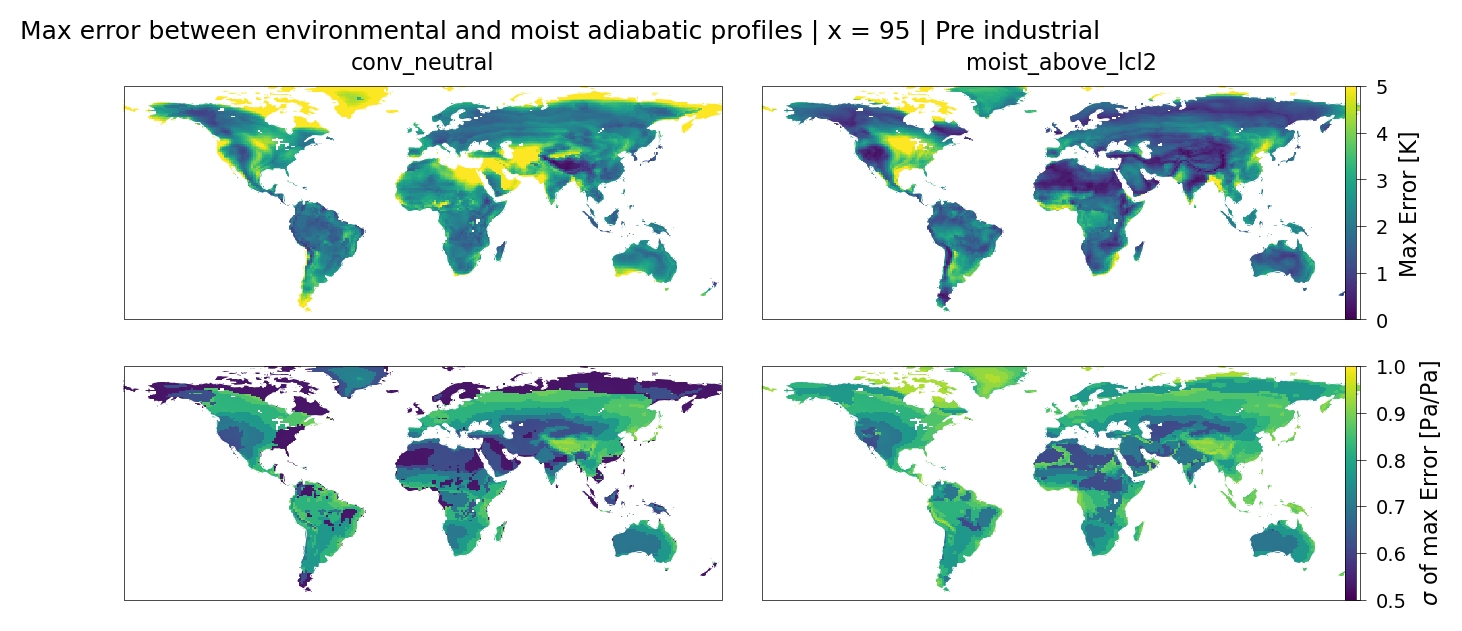

In [14]:
i = 0
fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 10, ar=2)
# for j, key in enumerate(['conv_neutral', 'moist_above_lcl']):
for j, key in enumerate(['conv_neutral', 'moist_above_lcl2']):
    im = ax[0, j].pcolormesh(ds[i].lon, ds[i].lat, np.abs(ds[i].T - ds_prof[i][key]).where(ds[i].p >= pressure_ft).max(dim='lev'), vmin=0, vmax=5)
    ind_max = np.abs(ds[i].T - ds_prof[i][key]).where(ds[i].p >= pressure_ft).fillna(0).argmax(dim='lev')
    im2 = ax[1, j].pcolormesh(ds[i].lon, ds[i].lat, (ds[i].p.isel(lev=ind_max)/ds[i].PS).where(land>0),
                              vmin=0.5, vmax=1)
    ax[0, j].set_title(key)
plt.colorbar(im, ax=ax[0].ravel(), fraction=0.01, pad=0.08, label='Max Error [K]')
plt.colorbar(im2, ax=ax[1].ravel(), fraction=0.01, pad=0.08, label='$\sigma$ of max Error [Pa/Pa]')
for ax_use in ax.flatten():
    ax_use.coastlines(lw=0.4, color='w')
fig.suptitle(f'Max error between environmental and moist adiabatic profiles | x = {quant} | {exp_labels[i]}', y=0.98, fontsize=9)
plt.subplots_adjust(wspace=-0.3)
plt.show()

### Profiles assuming constant lapse rate, split at a given level
These all follow constant lapse rate up to certain level, and then constant lapse rate above this level.

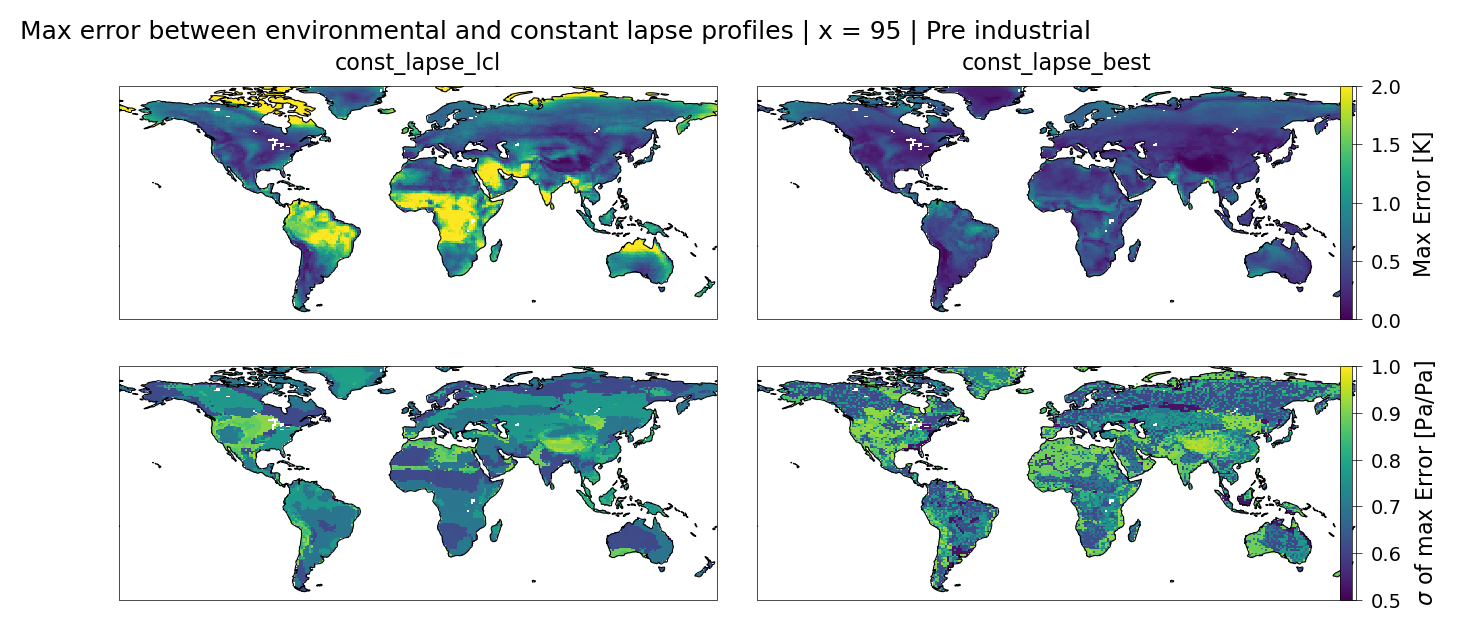

In [97]:
i = 0
error_mode = 'max'
fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 10, ar=2)
for j, key in enumerate(['const_lapse_lcl', 'const_lapse_best']):
    im = ax[0, j].pcolormesh(ds[i].lon, ds[i].lat, getattr(np.abs(ds[i].T - ds_prof[i][key]).where(ds[i].p >= pressure_ft), error_mode)(dim='lev'),
                             vmin=0, vmax=2 if error_mode == 'max' else 0.8)
    ind_max = np.abs(ds[i].T - ds_prof[i][key]).where(ds[i].p >= pressure_ft).fillna(0).argmax(dim='lev')
    im2 = ax[1, j].pcolormesh(ds[i].lon, ds[i].lat, (ds[i].p.isel(lev=ind_max)/ds[i].PS).where(land>0),
                              vmin=0.5, vmax=1)
    ax[0, j].set_title(key)
plt.colorbar(im, ax=ax[0].ravel(), fraction=0.01, pad=0.08, label=f'{error_mode.capitalize()} Error [K]')
plt.colorbar(im2, ax=ax[1].ravel(), fraction=0.01, pad=0.08, label=f'$\sigma$ of {error_mode.lower()} Error [Pa/Pa]')
for ax_use in ax.flatten():
    ax_use.coastlines(lw=0.4, color='k')
fig.suptitle(f'{error_mode.capitalize()} error between environmental and constant lapse profiles | x = {quant} | {exp_labels[i]}', y=0.98, fontsize=9)
plt.subplots_adjust(wspace=-0.3)
plt.show()

### Comparison of LCL and optimal splitting level
Below I compare the LCL level with the optimal level to reduce error given two lapse rate regimes. The difference is then shown below.

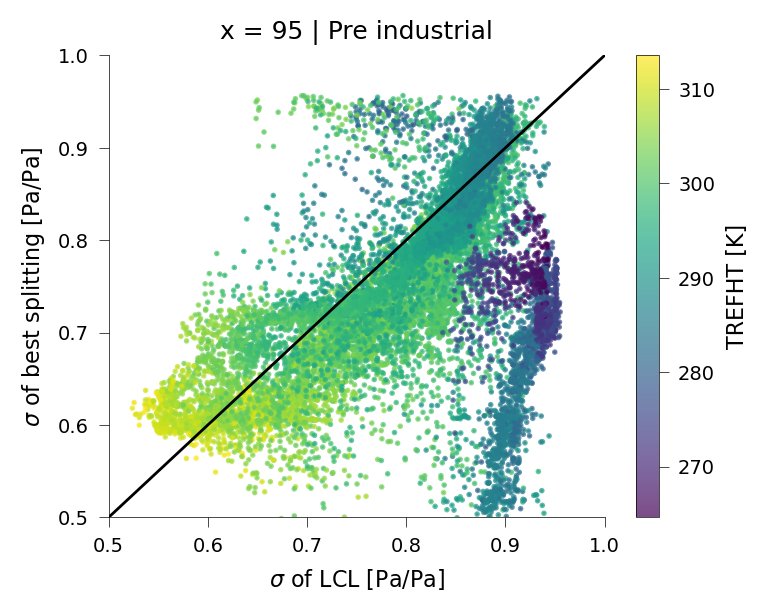

In [20]:
i=0
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 4)
im = ax.scatter(ds[i].p_lcl/ds[i].PS, ds_prof[i].const_lapse_best_p_split/ds[i].PS, s=1, c=ds[i].TREFHT, alpha=0.7)
plt.colorbar(im, ax=ax, label='TREFHT [K]')
ax.plot([0.5, 1], [0.5, 1], color='k')
ax.set_xlim(0.5, 1)
ax.set_ylim(0.5, 1)
ax.set_title(f'x = {quant} | {exp_labels[i]}', fontsize=9)
ax.set_xlabel('$\sigma$ of LCL [Pa/Pa]')
ax.set_ylabel('$\sigma$ of best splitting [Pa/Pa]')
update_linewidth(fig)
plt.show()

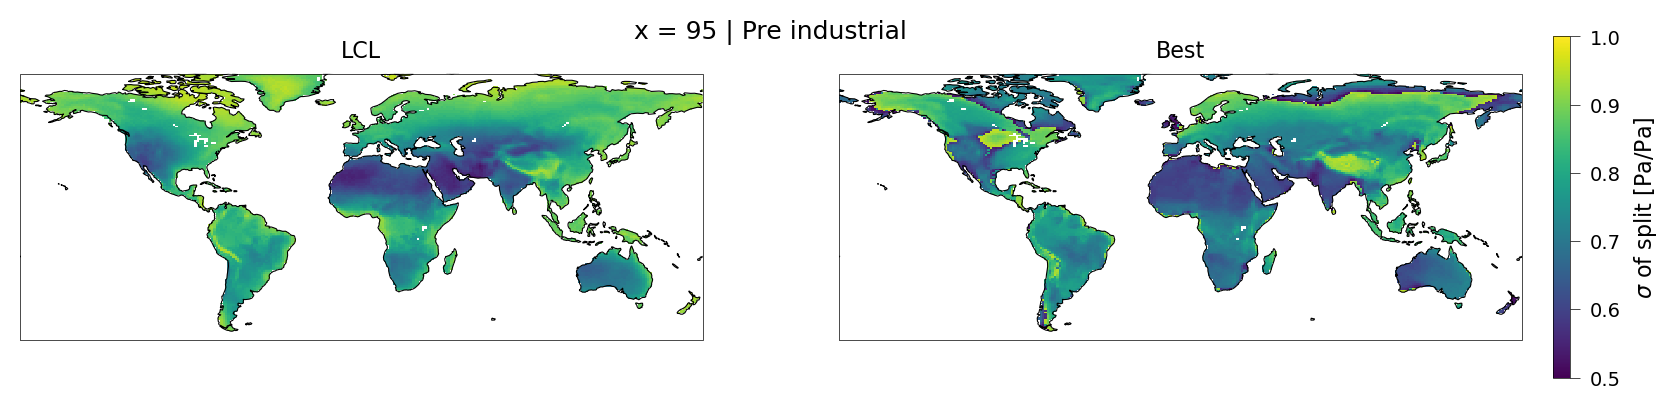

In [96]:
i = 0
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
ax[0].pcolormesh(ds[0].lon, ds[0].lat, ds[i].p_at_lcl/ds[i].PS, vmin=0.5, vmax=1)
im = ax[1].pcolormesh(ds[0].lon, ds[0].lat, ds_prof[i].const_lapse_best_p_split/ds[i].PS, vmin=0.5, vmax=1)
plt.colorbar(im, ax=ax.ravel(), fraction=0.011, pad=0.02, label='$\sigma$ of split [Pa/Pa]')
for j in range(len(ax)):
    ax[j].coastlines(lw=0.4, color='k')
ax[0].set_title('LCL')
ax[1].set_title('Best')
fig.suptitle(f'x = {quant} | {exp_labels[i]}', y=0.62, fontsize=9)
plt.show()

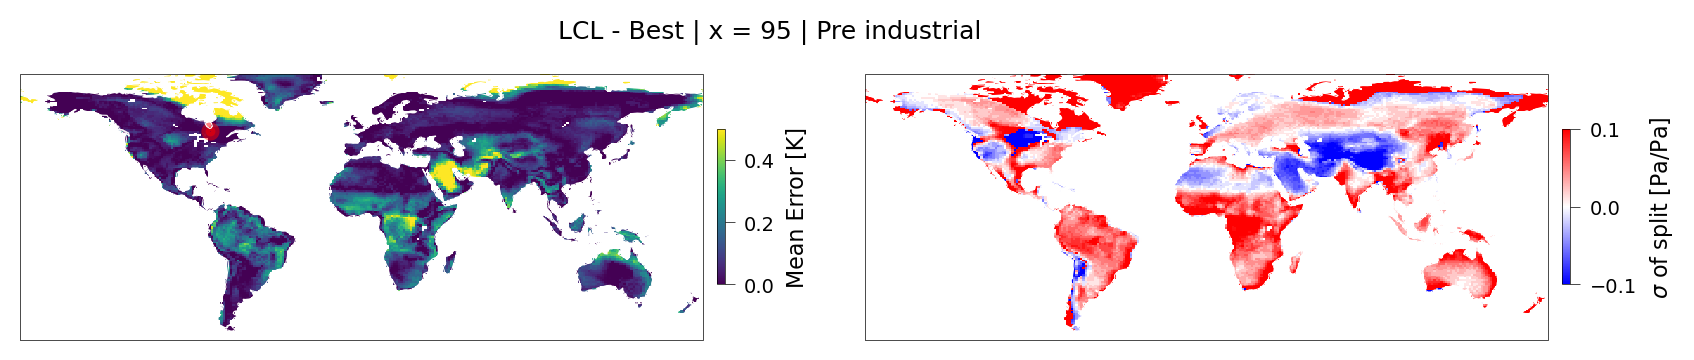

In [34]:
i = 0
error_mode = 'mean'
lat_plot = 50
lon_plot = 280
show_plot_loc = True
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
key = 'const_lapse_lcl'
key2 = 'const_lapse_best'
im = ax[0].pcolormesh(ds[0].lon, ds[0].lat, getattr(np.abs(ds[i].T - ds_prof[i][key]).where(ds[i].p >= pressure_ft), error_mode)(dim='lev') -
                      getattr(np.abs(ds[i].T - ds_prof[i][key2]).where(ds[i].p >= pressure_ft), error_mode)(dim='lev'),
                      vmin=0, vmax=1 if error_mode=='max' else 0.5, cmap='viridis')
if show_plot_loc:
    ax[0].scatter(lon_plot, lat_plot, s=50, marker='.', c='r', lw=3, alpha=0.5)
plt.colorbar(im, ax=ax[0], fraction=0.011, pad=0.02, label=f'{error_mode.capitalize()} Error [K]')
im = ax[1].pcolormesh(ds[0].lon, ds[0].lat, ds[i].p_at_lcl/ds[i].PS - ds_prof[i].const_lapse_best_p_split/ds[i].PS,
                      vmin=-0.1, vmax=0.1, cmap='bwr')
plt.colorbar(im, ax=ax[1], fraction=0.011, pad=0.02, label='$\sigma$ of split [Pa/Pa]')
for j in range(len(ax)):
    ax[j].coastlines(lw=0.4, color='w')
fig.suptitle(f'LCL - Best | x = {quant} | {exp_labels[i]}', y=0.62, fontsize=9)
plt.show()

### Error as function of latitude
This nicely summarises the findings that the `const_lapse` methods are better.

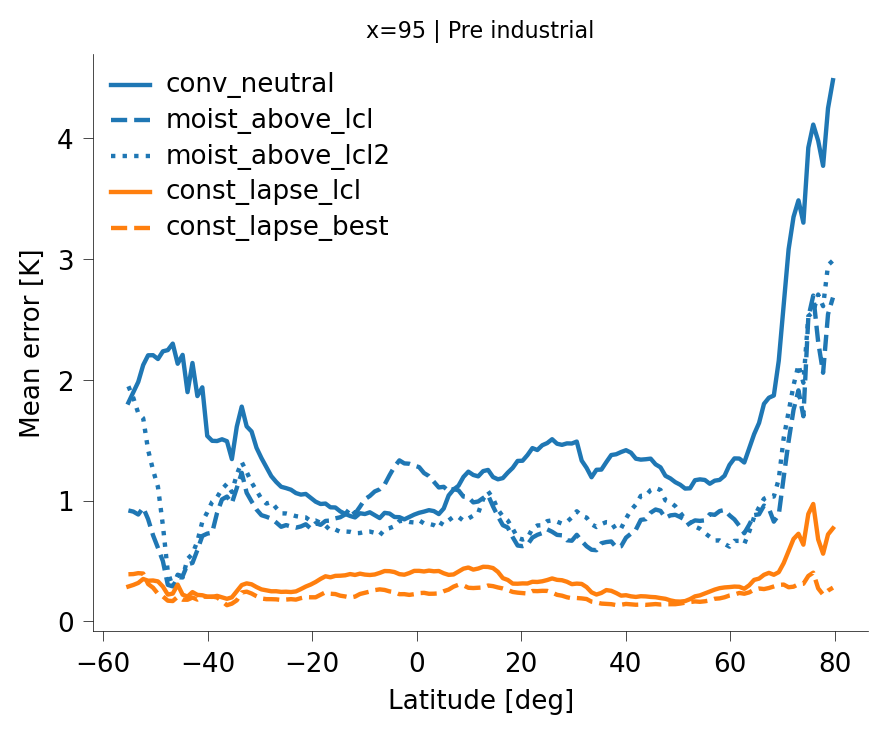

In [76]:
i=0
error_mode = 'mean'
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 5)
linestyles_use = ['-', '--', ':', '-', '--']
for j, key in enumerate(['conv_neutral', 'moist_above_lcl', 'moist_above_lcl2', 'const_lapse_lcl', 'const_lapse_best']):
    ax.plot(ds[i].lat, getattr(np.abs(ds[i].T - ds_prof[i][key]).where(ds[i].p >= pressure_ft), error_mode)(dim='lev').mean(dim='lon'),
            color='C0' if 'moist' in key or 'conv' in key else 'C1', label=key, linestyle=linestyles_use[j])
update_linewidth(fig)
ax.legend()
update_fontsize(fig, base_fontsize=6)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel(f'{error_mode.capitalize()} error [K]')
ax.set_title(f'x={quant} | {exp_labels[i]}')
plt.show()

## Change with warming

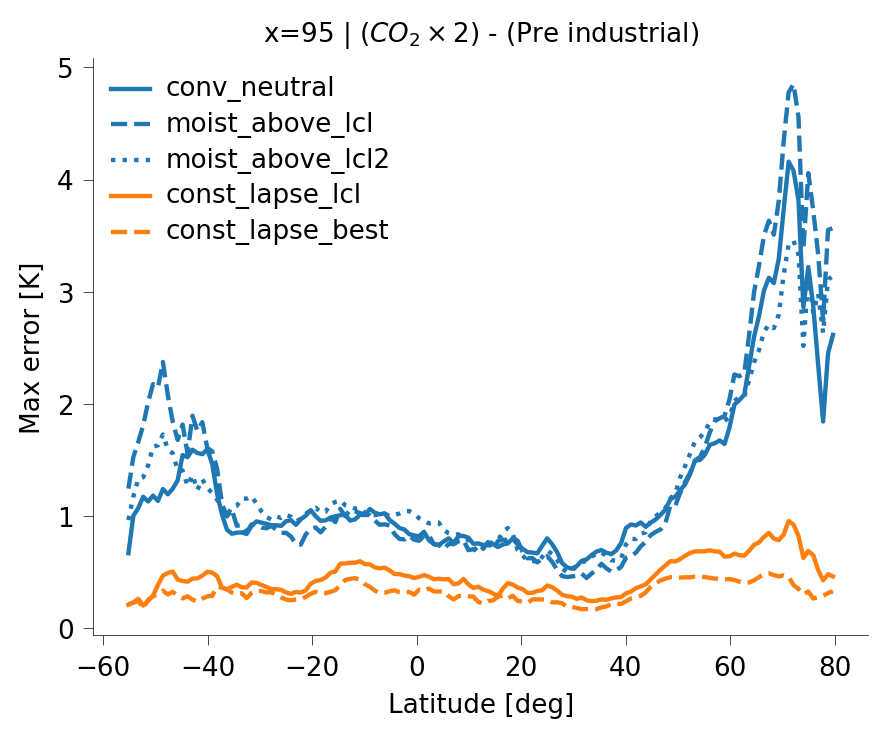

In [134]:
error_mode = 'max'
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 5)
linestyles_use = ['-', '--', ':', '-', '--']
for j, key in enumerate(['conv_neutral', 'moist_above_lcl', 'moist_above_lcl2', 'const_lapse_lcl', 'const_lapse_best']):
    ax.plot(ds[i].lat, getattr(np.abs(ds[1].T-ds[0].T - (ds_prof[1][key]-ds_prof[0][key])).where(ds[0].p >= pressure_ft), error_mode)(dim='lev').mean(dim='lon'),
            color='C0' if 'moist' in key or 'conv' in key else 'C1', label=key, linestyle=linestyles_use[j])
update_linewidth(fig)
ax.legend()
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel(f'{error_mode.capitalize()} error [K]')
ax.set_title(f'x={quant} | ({exp_labels[1]}) - ({exp_labels[0]})')
update_fontsize(fig, base_fontsize=6)
plt.show()

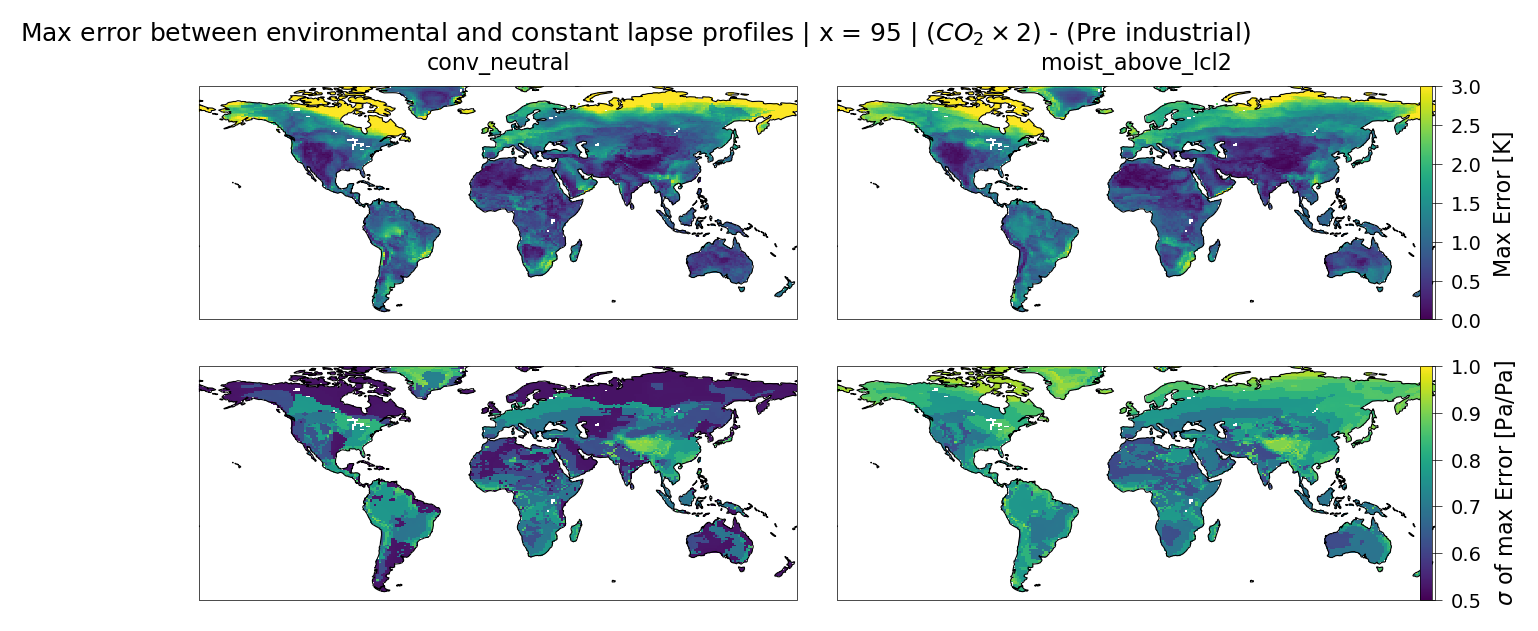

In [135]:
error_mode = 'max'
fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 10, ar=2)
keys = ['conv_neutral', 'moist_above_lcl2']
# keys = ['const_lapse_lcl', 'const_lapse_best']
vmax_use = {'max': 1.5, 'mean': 0.5} if 'const_lapse_best' in keys else {'max': 3, 'mean': 1}
for j, key in enumerate(keys):
    im = ax[0, j].pcolormesh(ds[i].lon, ds[i].lat,
                             getattr(np.abs(ds[1].T-ds[0].T - (ds_prof[1][key]-ds_prof[0][key])).where(ds[i].p >= pressure_ft), error_mode)(dim='lev'),
                             vmin=0, vmax=vmax_use[error_mode])
    ind_max = np.abs(ds[1].T-ds[0].T - (ds_prof[1][key]-ds_prof[0][key])).where(ds[i].p >= pressure_ft).fillna(0).argmax(dim='lev')
    im2 = ax[1, j].pcolormesh(ds[i].lon, ds[i].lat, (ds[0].p.isel(lev=ind_max)/ds[0].PS).where(land>0),
                              vmin=0.5, vmax=1)
    ax[0, j].set_title(key)
plt.colorbar(im, ax=ax[0].ravel(), fraction=0.01, pad=0.08, label=f'{error_mode.capitalize()} Error [K]')
plt.colorbar(im2, ax=ax[1].ravel(), fraction=0.01, pad=0.08, label=f'$\sigma$ of {error_mode.lower()} Error [Pa/Pa]')
for ax_use in ax.flatten():
    ax_use.coastlines(lw=0.4, color='k')
fig.suptitle(f'{error_mode.capitalize()} error between environmental and constant lapse profiles | x = {quant} | ({exp_labels[1]}) - ({exp_labels[0]})', y=0.98, fontsize=9)
plt.subplots_adjust(wspace=-0.3)
plt.show()

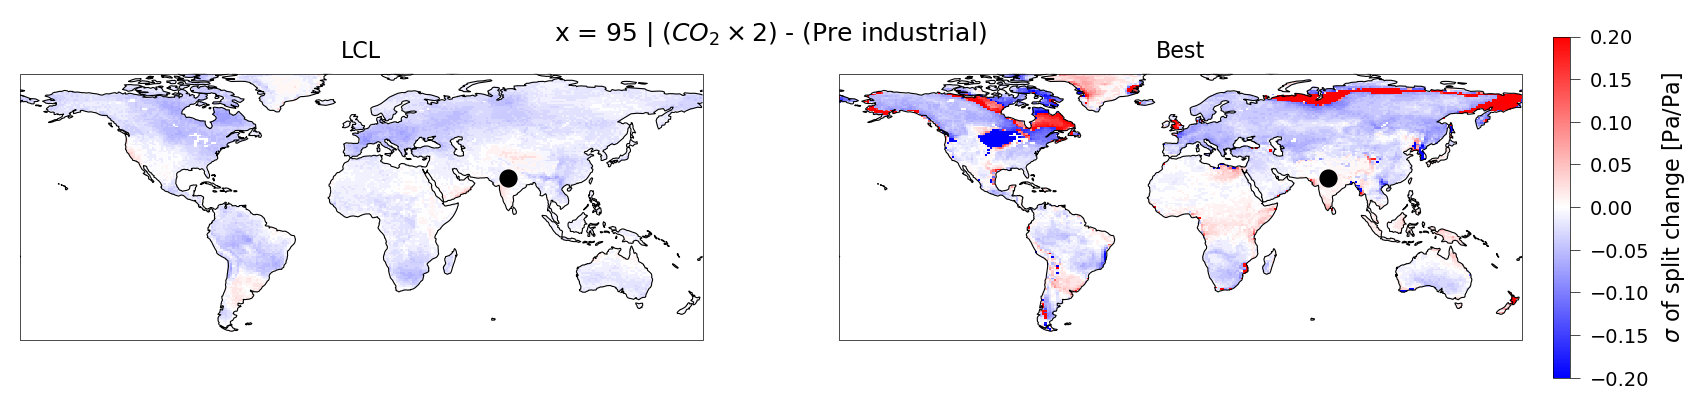

In [137]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
ax[0].pcolormesh(ds[0].lon, ds[0].lat, ds[1].p_at_lcl/ds[1].PS - ds[0].p_at_lcl/ds[0].PS, vmin=-0.2, vmax=0.2, cmap='bwr')
im = ax[1].pcolormesh(ds[0].lon, ds[0].lat, ds_prof[1].const_lapse_best_p_split/ds[1].PS -
                      ds_prof[0].const_lapse_best_p_split/ds[0].PS, vmin=-0.2, vmax=0.2, cmap='bwr')
plt.colorbar(im, ax=ax.ravel(), fraction=0.011, pad=0.02, label='$\sigma$ of split change [Pa/Pa]')
for j in range(len(ax)):
    ax[j].coastlines(lw=0.4, color='k')
    if show_plot_loc:
        ax[j].scatter(lon_plot, lat_plot, s=50, marker='.', c='k', lw=3, alpha=1)
ax[0].set_title('LCL')
ax[1].set_title('Best')
fig.suptitle(f'x = {quant} | ({exp_labels[1]}) - ({exp_labels[0]})', y=0.62, fontsize=9)
plt.show()

### Example Temperature Profiles

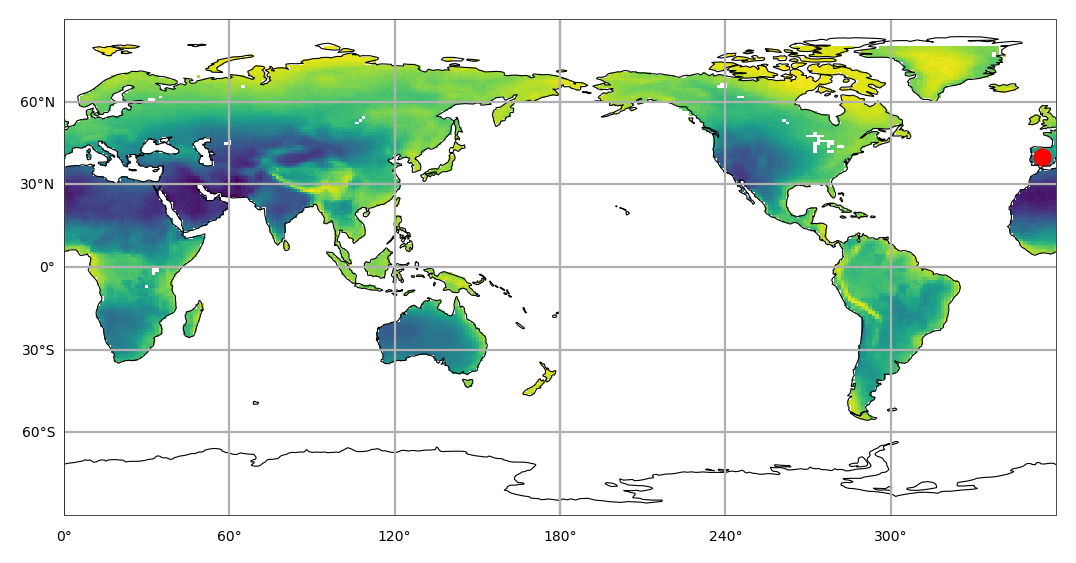

In [163]:
lat_plot = 40
lon_plot = 355
ds_use = [ds[i].sel(lat=lat_plot, lon=lon_plot, method='nearest')[['T', 'p', 'T_at_lcl', 'p_at_lcl', 'T_lcl', 'p_lcl']] for i in range(n_exp)]
for key in ds_prof[i]:
    for i in range(n_exp):
        ds_use[i][key] = ds_prof[i][key].sel(lat=lat_plot, lon=lon_plot, method='nearest')

show_plot_loc = True
proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': proj})
ax.pcolormesh(ds[0].lon, ds[0].lat, ds[0].p_at_lcl/ds[0].PS, transform=ccrs.PlateCarree())
ax.set_extent([0, 360, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines(lw=0.4, color='k')
gl=ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
def lon_formatter(x, pos):
    """Format longitudes from 0 to 360 without E/W"""
    x = x % 360  # wrap into 0–360
    return f"{int(x)}°"
gl.xformatter = FuncFormatter(lon_formatter)
gl.yformatter = cticker.LatitudeFormatter()
ax.scatter(lon_plot, lat_plot, s=50, marker='.', c='r', lw=3, alpha=1, transform=ccrs.PlateCarree())
if show_plot_loc:
    plt.show()
else:
    plt.close()

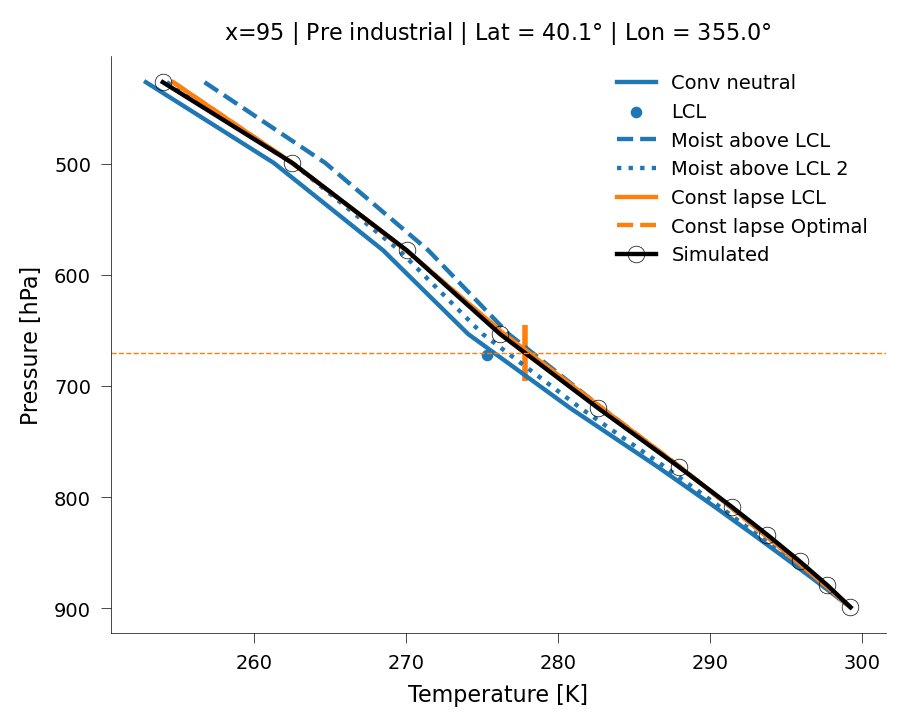

In [164]:
i = 0
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 5)
ax.plot(ds_use[i].conv_neutral, ds_use[i].p/100, color='C0', label='Conv neutral')
ax.scatter(ds_use[i].T_lcl, ds_use[i].p_lcl/100, color='C0', s=10, label='LCL')
ax.plot(ds_use[i].moist_above_lcl, ds_use[i].p/100, color='C0', linestyle='--', label='Moist above LCL')
ax.plot(ds_use[i].moist_above_lcl2, ds_use[i].p/100, color='C0', linestyle=':', label='Moist above LCL 2')
ax.plot(ds_use[i].const_lapse_lcl, ds_use[i].p/100, color='C1', label='Const lapse LCL')
ax.scatter(ds_use[i].T_at_lcl, ds_use[i].p_at_lcl/100, color='C1', s=400, lw=2, marker='|')
ax.plot(ds_use[i].const_lapse_best, ds_use[i].p/100, color='C1', linestyle='--', label='Const lapse Optimal')
ax.plot(ds_use[i].T, ds_use[i].p/100, color='k', marker='o', markersize=6, markerfacecolor='none', label='Simulated')
ax.invert_yaxis()
update_linewidth(fig)
ax.axhline(ds_use[i].p_split/100, color='C1', linestyle='--', lw=0.5)
ax.legend()
ax.set_title(f'x={quant} | {exp_labels[i]} | Lat = {ds_use[i].lat:.1f}$\degree$ | Lon = {ds_use[i].lon:.1f}$\degree$')
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [hPa]')
plt.show()

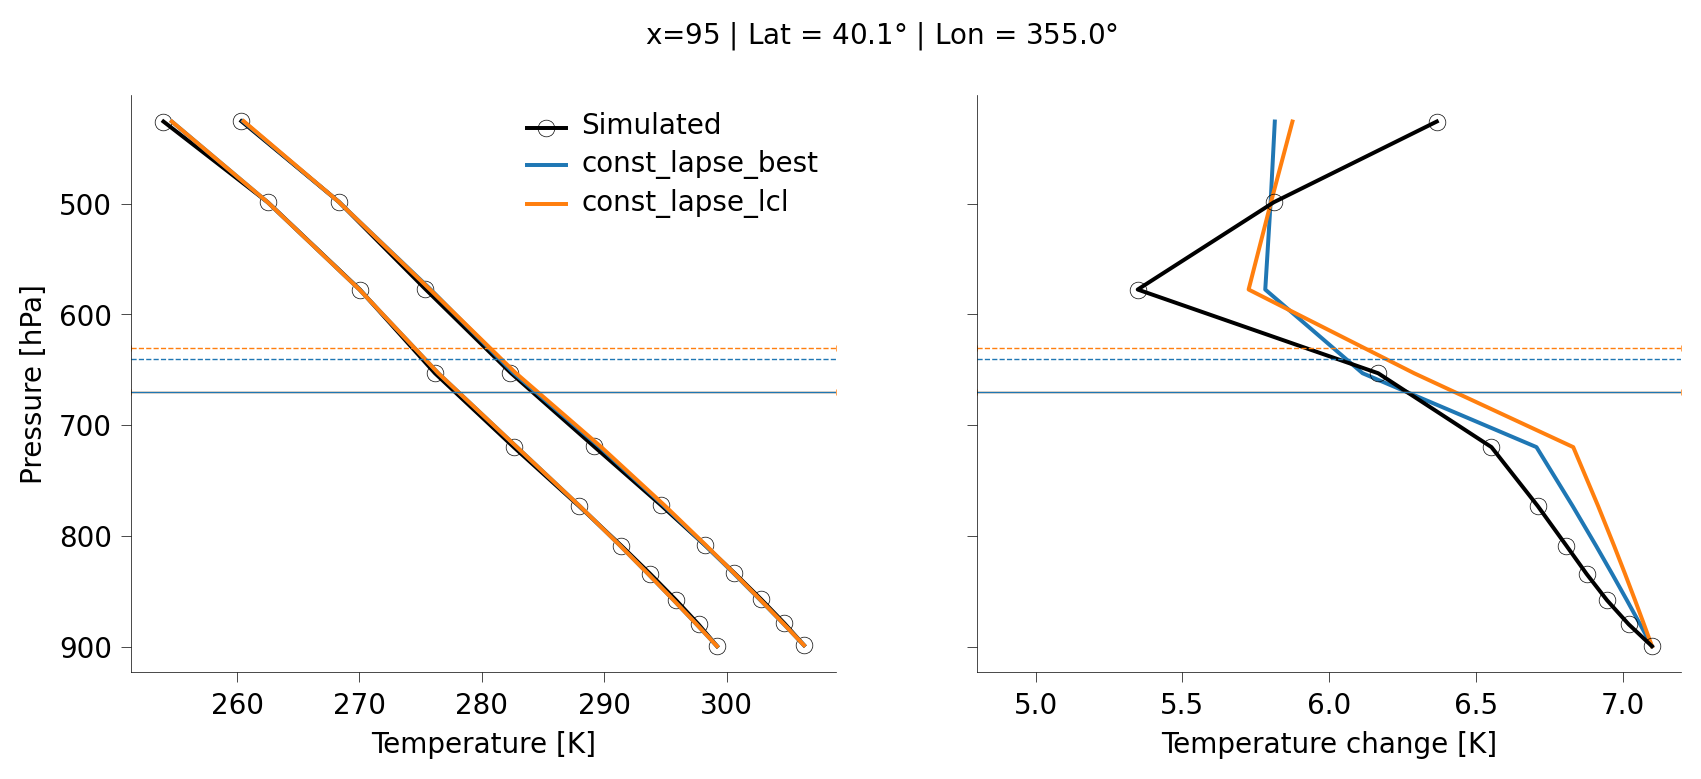

In [173]:
# keys = ['conv_neutral', 'moist_above_lcl2']
keys = ['const_lapse_best', 'const_lapse_lcl']
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
for i in range(n_exp):
    ax[0].plot(ds_use[i].T, ds_use[i].p/100, color='k', marker='o', markersize=6, markerfacecolor='none', label='Simulated' if i==0 else None)
    for j, key in enumerate(keys):
        ax[0].plot(ds_use[i][key], ds_use[i].p/100, color=f'C{j}', label=key if i==0 else None)
        if i==0:
            ax[1].plot(ds_use[1][key]-ds_use[0][key], ds_use[0].p/100, color=f'C{j}', label=key)
ax[1].plot(ds_use[1].T-ds_use[0].T, ds_use[0].p/100, color='k', marker='o', markersize=6, markerfacecolor='none')
ax[0].invert_yaxis()
fig.suptitle(f'x={quant} | Lat = {ds_use[i].lat:.1f}$\degree$ | Lon = {ds_use[i].lon:.1f}$\degree$')
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('Temperature change [K]')
update_linewidth(fig)
for i in range(n_exp):
    for j in range(len(ax)):
        ax[j].axhline(ds_use[i].p_at_lcl/100, color='C1', marker='|', linestyle='--' if i==1 else '-')
        if 'const_lapse_best' in keys:
            ax[j].axhline(ds_use[i].p_split/100, color='C0', linestyle='--' if i==1 else None, lw=0.5)
ax[0].legend()
update_fontsize(fig, base_fontsize=7)
# ax[1].set_xlim(4.8, 7.2)
plt.show()